# Project 2 - Starter Notebook

Please make sure your solution is divided into multiple code cells, explained clearly and properly, and most importantly, pretty.


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import os,time
from pyspark.sql import SparkSession

#Feature Extraction
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler

#Visual Analysis
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

#Clustering 
from pyspark.ml.clustering import KMeans

#Dividing households into subsets 
from pyspark.sql.window import Window
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()

## Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("dbfs:/FileStore/project_b_data/proj_B_demographic/")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1
4046,4,3,3,M,W,S,O,6,0.075,0.05,F,1
4303,1,1,1,S,W,S,O,15,0.15,0.2,M,1
4559,3,2,2,S,W,S,O,12,0.175,0.2,F,2
5277,3,2,2,M,W,S,R,15,0.125,0.02,M,2
5440,1,1,1,S,W,S,O,8,0.225,0.2,F,1


## Read Static Viewing Data

In [0]:
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("event_date", StringType(), True),
    StructField("event_time", StringType(), True),     
    StructField("station_num", IntegerType(), True),
    StructField("prog_code", StringType(), True),
    StructField("household_id", IntegerType(), True)
])

viewing_static_df = spark.read.schema(schema).option("header", True).csv("dbfs:/FileStore/project_b_data/viewing_static_csv/")

viewing_static_df.printSchema()
display(viewing_static_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: integer (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
001bd74cc8d1,20150120,181338,75523,EP000009110053,3783713
10ea5940d694,20150120,181338,11218,MV001054110000,3787015
44e08ed80c35,20150120,181338,11713,SH004464010000,43921
0000048de4f2,20150120,181338,65626,MV000506130000,3672067
0000059867a7,20150120,181338,58812,EP019199930005,3645541
000011ff9ba9,20150120,181338,18510,EP010855880111,3642303
00000254e5f6,20150120,181338,35513,EP000369550087,3825751
000002bd8a47,20150120,181338,10035,EP013413450102,2971023
000003c4c597,20150120,181338,59337,MV000744670000,2358722
00407bba00fe,20150120,181338,14771,EP015899250028,2838674


## Static Data Analysis (65 points)

### Feature Extraction

In [0]:
# copy the demographic DataFrame so the original stays intact
demographic_copy = demographic_df

# dividing the columns to categorical and numerical
numeric_cols = [
    "household_size",
    "num_adults",
    "num_generations",
    "length_residence",
    "home_market_value",
    "net_worth"
]
# we won't change the household_id column because it's an identifier and not a feature.
categorial_cols = [
    "marital_status",
    "race_code",
    "dwelling_type",
    "home_owner_status",
    "gender_individual",
    "education_highest"
]

# drop any previous index or vec columns to avoid collisions
demographic_copy = demographic_copy.drop(
    *[c for c in demographic_copy.columns if c.endswith("_index") or c.endswith("_vec")]
)

# 1. extraction of min and max of each numeric column
# for me: the star is like a wildcard, it will take all the columns in the list
stats = demographic_copy.select(
    *[min(c).alias(c + "_min") for c in numeric_cols],
    *[max(c).alias(c + "_max") for c in numeric_cols]
).collect()[0]

# normalizing the numeric columns (x-min)/(max-min)
for field in numeric_cols:
    min_val = stats[f"{field}_min"]
    max_val = stats[f"{field}_max"]
    rng     = max_val - min_val if max_val != min_val else 1
    demographic_copy = demographic_copy.withColumn(
        f"{field}_scaled",
        (col(field) - min_val) / rng
    )

# one hot encoding 
# FOR ME: string indexer maps a string column of labels to a column of label indices. 
# Setting handleInvalid="skip" drops rows with unseen / null categories so we don't add an extra 'unknown' level.
for c in categorial_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="skip")
    demographic_copy = indexer.fit(demographic_copy).transform(demographic_copy)

# FOR ME: one hot encoding converts the indexed categories to binary vectors
# dropLast=True removes the last dummy to avoid linear dependence and reduce dimensions
encoder = OneHotEncoder(
    inputCols =[c + "_index" for c in categorial_cols],
    outputCols=[c + "_vec"   for c in categorial_cols],
    dropLast=True
)
demographic_copy = encoder.fit(demographic_copy).transform(demographic_copy)

# assembling all features into a single vector
assembler = VectorAssembler(
    inputCols=[f"{c}_scaled" for c in numeric_cols]
            + [f"{c}_vec"    for c in categorial_cols],
    outputCol="features"
)

# apply it
assembled_df = assembler.transform(demographic_copy)

# 4.7: Select only the ID and the assembled vector, then show 7 rows un-truncated
result_df = assembled_df.select("household_id", "features")

result_df.show(7, truncate=False)


🏃 View run chill-pug-290 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158/runs/0c81230ff2a243a8b45a4bd0e88bac8c
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158
🏃 View run honorable-midge-52 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158/runs/4ed6b5c0ad5d4a02a4c71e88d780df81
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158
🏃 View run handsome-gull-778 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158/runs/d7b45ace750d47eda3ab545291d09a28
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158
🏃 View run traveling-pig-827 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158/runs/d89700d325a542388d53ca38b24a96a8
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/expe

### Visual Analysis

🏃 View run fun-vole-379 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158/runs/08515df935e749d5bec122671d4dec20
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158


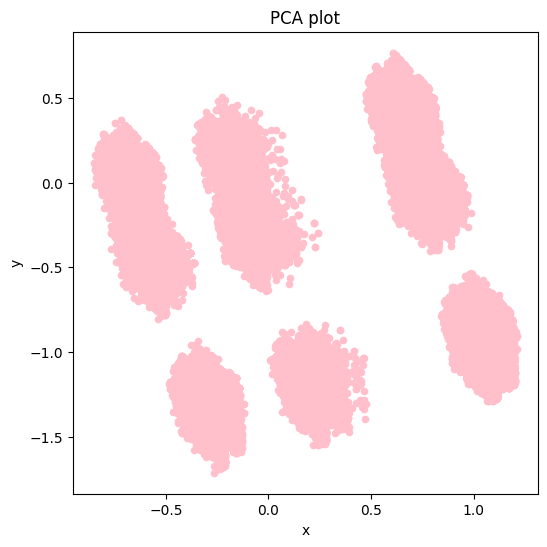

+------------+--------------------+--------------------+
|household_id|x                   |y                   |
+------------+--------------------+--------------------+
|85          |0.7696161667682884  |-0.14328450444325927|
|2073        |1.0470607429479755  |-0.8077002155153584 |
|2523        |-0.2156446172043766 |-1.6496380625532252 |
|2717        |-0.14727133330514708|-0.00987810853388306|
|3364        |1.0866265581511152  |-1.0202633541472848 |
|4046        |0.964064307619732   |-0.9501483206226214 |
|4303        |0.6852258565823549  |0.3318621809840816  |
+------------+--------------------+--------------------+
only showing top 7 rows



In [0]:


# fitting the PCA model on my features vector from the feature extraction cell 
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(result_df)

# projecting the feature vectors onto R^2
pca_df = pca_model.transform(result_df)

# extracting the coordinations 
# convert vector to array so we can index into it
pca_df = (pca_df
          .withColumn("arr", vector_to_array("pca_features"))
          .withColumn("x", col("arr")[0])
          .withColumn("y", col("arr")[1])
          .drop("pca_features", "arr")
         )

# converting to Pandas for plotting 
pdf = pca_df.select("x", "y").toPandas()

# plotting a pink scatter plot
ax = pdf.plot.scatter(
    x="x",
    y="y",
    color="pink",
    figsize=(6,6),
    title="PCA plot"
)
plt.show()
#showing 7 rows from the resulting DataFrame 
pca_df.select("household_id", "x", "y").show(7, truncate=False)


### Clustering

In [0]:

# fitting the kmeans 
# as explained in the pdf, the number of clusters is 6 
c = 6
kmeans = KMeans(k=c, seed=3, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(result_df)

# assigning each household_id to a cluster 
cluster_df = model.transform(result_df)

# computing the euclidean distance of each household from its cluster's centroid
# pull out the centroids as plain Python lists
centers = [list(vec) for vec in model.clusterCenters()]

def euclidean_distance(point, cluster_idx):
    arr = list(point)                    # works for Spark Vector or numpy array
    center = centers[int(cluster_idx)]   # select the right centroid list
    total = 0.0
    for a, c_val in zip(arr, center):
        diff = a - c_val
        total += diff * diff
    return float(total ** 0.5)           # exponent instead of math.sqrt

distance_udf = udf(euclidean_distance, FloatType())

cluster_df = cluster_df.withColumn(
    "distance",
    distance_udf(col("features"), col("cluster"))
)

# show 7 rows to verify
cluster_df.select("household_id", "cluster", "distance").show(7, truncate=False)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run gentle-stag-157 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158/runs/d66ffc199b2248189d8aa7054ff5b929
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/3438122205037158
+------------+-------+----------+
|household_id|cluster|distance  |
+------------+-------+----------+
|85          |1      |0.95686495|
|2073        |2      |0.8481486 |
|2523        |0      |1.329641  |
|2717        |1      |1.4315091 |
|3364        |5      |0.5861586 |
|4046        |5      |0.9358106 |
|4303        |1      |0.9705721 |
+------------+-------+----------+
only showing top 7 rows



### Dividing households into subsets

In [0]:

# 1. order households within each cluster by their distance
win = Window.partitionBy("cluster").orderBy(col("distance"))

# 2. attach a 1-based rank within each cluster
ranked_df = cluster_df.withColumn("rank", row_number().over(win))

# 3. build the subsets
full_subset         = ranked_df
thirds_subset       = ranked_df.filter(col("rank")  % 3  == 0)
seventeenths_subset = ranked_df.filter(col("rank")  % 17 == 0)

# 4. show 7 rows from each (note we now select "rank", not "rank_in_cluster")
print("Full subset:")
full_subset.select("household_id","cluster","distance","rank") \
           .show()

print("3rds subset:")
thirds_subset.select("household_id","cluster","distance","rank") \
             .show()

print("17ths subset:")
seventeenths_subset.select("household_id","cluster","distance","rank") \
                   .show()


Full subset:
+------------+-------+----------+----+
|household_id|cluster|  distance|rank|
+------------+-------+----------+----+
|     2870796|      1|0.80247897|   1|
|     3631022|      1|0.80305946|   2|
|     3799062|      1|0.80305946|   3|
|     2357515|      1|0.80305946|   4|
|      107954|      1| 0.8031158|   5|
|     4687821|      1| 0.8036958|   6|
|     4015214|      1| 0.8045011|   7|
|     1593608|      1| 0.8045011|   8|
|     4072047|      1| 0.8045011|   9|
|     4022673|      1| 0.8045011|  10|
|     1260153|      1| 0.8045011|  11|
|     1943075|      1| 0.8046441|  12|
|     1956750|      1| 0.8050801|  13|
|     2717503|      1| 0.8050801|  14|
|     3296964|      1| 0.8051363|  15|
|     4687363|      1| 0.8051363|  16|
|     2516133|      1| 0.8051363|  17|
|     3792813|      1| 0.8051363|  18|
|     2745500|      1| 0.8052203|  19|
|       38392|      1|  0.805223|  20|
+------------+-------+----------+----+
only showing top 20 rows

3rds subset:
+-----------

### Cluster’s Viewing Analysis

In [0]:

# helper: count viewing events per station
def count_views_per_station(sub_df, name: str, clustered: bool = True):
    if clustered:
        joined = sub_df.join(viewing_static_df, "household_id")
        gb = joined.groupBy(
            lit(name).alias("subset"),
            col("cluster"),
            col("station_num")
        )
    else:
        gb = viewing_static_df.groupBy(
            lit(name).alias("subset"),
            col("station_num")
        )
    return gb.count()

# counts for each subset
full_c   = count_views_per_station(full_subset,        "full")
thirds_c = count_views_per_station(thirds_subset,      "3rds")
sev17_c  = count_views_per_station(seventeenths_subset,"17ths")
all_c    = full_c.unionByName(thirds_c).unionByName(sev17_c)

# subset-level ratings
w_sub = Window.partitionBy("subset", "cluster")
pct_df = (
    all_c
    .withColumn("subset_total", sum("count").over(w_sub))
    .withColumn("subset_rating", col("count") / col("subset_total") * 100)
    .select("subset", "cluster", "station_num", "subset_rating")
)

# general population ratings
general_c   = viewing_static_df.groupBy("station_num").count()
overall_tot = general_c.agg(sum("count")).first()[0]
general_pop = (
    general_c
    .withColumn("general_rating", col("count") / lit(overall_tot) * 100)
    .select("station_num", "general_rating")
)

# diff_rank calculation
diff_df = (
    pct_df.join(general_pop, "station_num", "left")
    .na.fill({"general_rating": 0})
    .withColumn("diff_rank", col("subset_rating") - col("general_rating"))
)

# keep top-7 per subset and cluster
top7_df = (
    diff_df
    .withColumn(
        "r",
        row_number().over(
            Window.partitionBy("subset", "cluster").orderBy(col("diff_rank").desc())
        )
    )
    .filter(col("r") <= 7)
    .drop("r")
)

# build HTML
subset_names = ["3rds", "17ths", "full"]
css = """
<style>
  .clusterBox{background:#1c1c1e;padding:14px;margin:22px 0;border:1px solid #444;}
  h2{margin:0 0 14px 0;font-family:monospace;color:#fff;}
  h4{margin:4px 0 8px 0;font-family:monospace;color:#ddd;text-align:center;}
  .row{white-space:nowrap;}
  table{border-collapse:collapse;font-family:monospace;font-size:13px;}
  th{background:#333;color:#fff;padding:6px 12px;border:1px solid #555;}
  td{background:#202124;color:#e8e8e8;padding:6px 12px;border:1px solid #555;}
  tr:nth-child(even) td{background:#262729;}
</style>
"""

html_parts = [css]
for cid in range(6):
    inner = []
    for subset in subset_names:
        pdf = (
            top7_df
            .filter((col("cluster") == cid) & (col("subset") == subset))
            .orderBy(col("diff_rank").desc())
            .select("station_num", "diff_rank")
            .toPandas()
        )
        inner.append(f"""
        <div style="display:inline-block; vertical-align:top; margin-right:36px;">
          <h4>Subset {subset}</h4>
          {pdf.to_html(index=False, border=0, float_format='%.12f')}
        </div>""")
    html_parts.append(f"""
    <div class="clusterBox">
      <h2>Cluster {cid}</h2>
      <div class="row">{''.join(inner)}</div>
    </div>""")

html = "\n".join(html_parts)

# display HTML
try:
    displayHTML(html)          # Databricks
except NameError:
    from IPython.display import HTML, display
    display(HTML(html))        # Jupyter / VS Code / Colab


station_num,diff_rank
60179,0.311424546703
49788,0.229716408600
16374,0.143882978338
32645,0.129208245124
11221,0.128524970984
45507,0.122843254025
65732,0.099847186724
station_num,diff_rank
16374,0.474174185199
11069,0.316980631003


## Dynamic Data Analysis - Streaming (35 points)

In [0]:
import time
#ALL THE COMMENTS IN THIS CELL ARE FOR ME ONLY (FOR BETTER UNDERSTANDING OF THE CODE)
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id INT"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
#upper bound for number of 
OFFSETS_PER_TRIGGER = 50000


streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")


In [0]:
from IPython.display import display

# This dictionary will store the running counts for each station within each cluster.
# Key: (cluster, station_num), Value: count
cluster_incremental_counts = {}

# This dictionary will store the running counts for each station from the ENTIRE stream.
# Key: station_num, Value: count
global_incremental_counts = {}

# A counter to keep track of the batch number for display purposes.
batch_counter = 0


In [0]:
def process_streaming_batch(batch_df, epoch_id):
    """Process a streaming batch of data."""
    global batch_counter, cluster_incremental_counts, global_incremental_counts

    print(f"--- Batch {batch_counter} ---")

    if batch_df.rdd.isEmpty():
        print("No new data in this batch.")
        print("-" * 25)
        batch_counter += 1
        return

    # 1. Update GLOBAL station counts using the entire incoming batch
    global_counts_in_batch = batch_df.groupBy("station_num").count().collect()
    for row in global_counts_in_batch:
        station = row['station_num']
        count = row['count']
        global_incremental_counts[station] = global_incremental_counts.get(station, 0) + count

    # 2. Update CLUSTER-SPECIFIC counts by joining with the '3rds' subset
    joined_df = batch_df.join(thirds_subset, "household_id")
    cluster_counts_in_batch = joined_df.groupBy("cluster", "station_num").count().collect()
    for row in cluster_counts_in_batch:
        cluster, station, count = row['cluster'], row['station_num'], row['count']
        key = (cluster, station)
        cluster_incremental_counts[key] = cluster_incremental_counts.get(key, 0) + count

    # 3. Create a DataFrame for GENERAL ratings from the cumulative stream data
    
    # use Python's built-in sum to avoid conflict with Spark's sum function.
    total_stream_views = __builtins__.sum(global_incremental_counts.values())
    
    if total_stream_views == 0:
        print("No viewing data processed yet.")
        batch_counter += 1
        return

    global_rows = [(k, v) for k, v in global_incremental_counts.items()]
    global_schema = StructType([StructField("station_num", StringType(), False), StructField("count", LongType(), False)])
    general_ratings_df = (
        spark.createDataFrame(global_rows, global_schema)
        .withColumn("general_rating", (col("count") / total_stream_views) * 100)
        .select("station_num", "general_rating")
    )

    # 4. Create a DataFrame for SUBSET ratings from the cumulative stream data
    if not cluster_incremental_counts:
        print("No viewing data for the target subset has arrived yet.")
        print("-" * 25)
        batch_counter += 1
        return

    cluster_rows = [(k[0], k[1], v) for k, v in cluster_incremental_counts.items()]
    cluster_schema = StructType([StructField("cluster", IntegerType(), False), StructField("station_num", StringType(), False), StructField("count", LongType(), False)])
    cluster_cumulative_df = spark.createDataFrame(cluster_rows, cluster_schema)
    
    subset_ratings_df = (
        cluster_cumulative_df
        .withColumn("subset_total", sum("count").over(Window.partitionBy("cluster")))
        .withColumn("subset_rating", (col("count") / col("subset_total")) * 100)
    )

    # 5. Join, calculate diff_rank, and identify the top 7 stations
    diff_rank_df = subset_ratings_df.join(general_ratings_df, "station_num", "left").na.fill(0) \
        .withColumn("diff_rank", col("subset_rating") - col("general_rating"))

    top7_df = diff_rank_df.withColumn("rank", row_number().over(Window.partitionBy("cluster").orderBy(col("diff_rank").desc()))) \
        .filter(col("rank") <= 7)

    
    # --- Display Results ---
    cluster_ids_with_data = [row.cluster for row in top7_df.select("cluster").distinct().collect()]
    
    # Loop through each cluster and display its top stations
    for cid in sorted(cluster_ids_with_data):
        print(f"\nCluster {cid} - Top 7 Stations:")
        
        top7_df.filter(col("cluster") == cid) \
         .select("rank", "station_num", "diff_rank") \
         .orderBy("rank") \
         .show(truncate=False)

    print("-" * 25)
    batch_counter += 1

In [0]:
streaming_query = (
    streaming_df.writeStream
    .foreachBatch(process_streaming_batch)
    .outputMode("update")
    .start()
)


# Wait, let few batches finish
time.sleep(200)
streaming_query.stop()

--- Batch 0 ---

Cluster 0 - Top 7 Stations:
+----+-----------+-------------------+
|rank|station_num|diff_rank          |
+----+-----------+-------------------+
|1   |11150      |0.5176462585034014 |
|2   |11164      |0.4717868480725623 |
|3   |15342      |0.3262040816326531 |
|4   |19630      |0.3155827664399093 |
|5   |10021      |0.30599546485260765|
|6   |10142      |0.2923401360544219 |
|7   |64312      |0.26751473922902497|
+----+-----------+-------------------+


Cluster 1 - Top 7 Stations:
+----+-----------+-------------------+
|rank|station_num|diff_rank          |
+----+-----------+-------------------+
|1   |18480      |0.41517329176409457|
|2   |14771      |0.364865679397246  |
|3   |10145      |0.3609618082618862 |
|4   |11765      |0.35748090413094313|
|5   |15433      |0.33538477526630306|
|6   |11187      |0.3186349701221096 |
|7   |12131      |0.27903871135359837|
+----+-----------+-------------------+


Cluster 2 - Top 7 Stations:
+----+-----------+------------------+

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 642, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/spark/python/pyspark/sql/utils.py", line 132, in call
    raise e
  File "/databricks/spark/python/pyspark/sql/utils.py", line 129, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/root/.ipykernel/1232/command-7123004855802757-304420841", line 72, in process_streaming_batch
    cluster_ids_with_data = [row.cluster for row in top7_df.select("cluster").distinct().collect()]
                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/spark/python/pyspark/instrumentation_utils.py", line 47, in wrapper
    res = func(*args,